<a href="https://colab.research.google.com/github/sony-panakkal/project/blob/main/SITSA_RESULT_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Pointbreak82/Satellite-Image-Time-Series-.git
!mkdir ~/.kaggle
!cp /content/Satellite-Image-Time-Series-/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d artelabsuper/sentinel2-munich480

Cloning into 'Satellite-Image-Time-Series-'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (22/22), 385.54 KiB | 7.41 MiB/s, done.
Resolving deltas: 100% (9/9), done.
100% 15.5G/15.5G [02:31<00:00, 149MB/s]
100% 15.5G/15.5G [02:31<00:00, 110MB/s]


In [ ]:
!pip install rasterio
!pip install scikit-image
!pip install tqdm
!pip install visdom==0.1.8.4
!pip3 install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for visdom: filename=visdom-0.1.8.4-py3-none-any.whl size=226637 sha256=66f1a7542dbc592137785eff7008f49f28e8e8756ee1ef33f81f0d5c290404ae
  Stored in directory: /root/.cache/pip/wheels/68/06/68/a32a0050c901f9c25fd027b9a5bb97e815157090168a1c89aa
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5692 sha256=226ccf8f9d736c500cea3e5ffdd66f6ed998c16d6342d6bb770feaafcb3a6d4d
  Stored in directory: /root/.cache/pip/wheels/c7/e9/87/1c51daf8e468d5c14931f8ac3344880f903ba96b063675cac2
Successfully built visdom torchfile


In [ ]:
import os
import zipfile
from tqdm import tqdm


zip_file_name = 'sentinel2-munich480.zip'


target_directory = '/content/sentinel2-munich480'


os.makedirs(target_directory, exist_ok=True)


with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    total_files = len(zip_ref.infolist())


with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    for file_info in tqdm(zip_ref.infolist(), desc="Extracting", unit=" files", ncols=100):
        zip_ref.extract(file_info, target_directory)

Extracting: 100%|███████████████████████████████████| 2298627/2298627 [11:43<00:00, 3268.46 files/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import time
import torch.utils.data
import os
import sys
import rasterio
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F


In [ ]:
#Configuration and Hyperparameters

root_path = '/content/sentinel2-munich480/munich480'
result_path = '/content/working/'
# resume_path = '/content/drive/MyDrive/UNET OUTPUT/best_model.pth'#'/content/working/best_model.pth'
result_train = 'train_results.txt'
result_validation = 'validation_results.txt'
no_of_classes = 18
workers = 8
batch_size = 2
h = w = 7
n_classes = 18
LABEL_FILENAME = "y.tif"
best_test_acc = 0
loss = 'ndvi'
ottimizzatore = 'sgd'
learning_rate = 0.01
weight_decay = 1e-5
momentum = 0.9
loss_weights = 'store_true'
ignore_index = 0
test_only = False
sample_duration = 30
n_epochs = 20

num_folds = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
warnings.filterwarnings("ignore")


In [ ]:
#DATALOADER
LABEL_FILENAME = "y.tif"
class SentinelDataset(torch.utils.data.Dataset):


    def __init__(self, root_dir, seqlength=30, tileids=None):
        self.root_dir = root_dir
        self.name = os.path.basename(root_dir)
        self.data_dirs = [d for d in os.listdir(self.root_dir) if d.startswith("data")]
        self.seqlength = seqlength
        self.munich_format = None
        self.src_labels = None
        self.dst_labels = None
        self.unique_labels = np.array([], dtype=float)

        self.b8_index = 3
        self.b4_index = 2

        stats = dict(
            rejected_nopath=0,
            rejected_length=0,
            total_samples=0)

        # statistics
        self.samples = list()

        self.ndates = list()

        dirs = []
        if tileids is None:
            for d in self.data_dirs:
                dirs_name = os.listdir(os.path.join(self.root_dir, d))
                dirs_path = [os.path.join(self.root_dir, d, f) for f in dirs_name]
                dirs.extend(dirs_path)
        else:

            with open(os.path.join(self.root_dir, tileids), 'r') as f:
                files = [el.replace("\n", "") for el in f.readlines()]
            for d in self.data_dirs:
                dirs_path = [os.path.join(self.root_dir, d, f) for f in files]
                dirs.extend(dirs_path)

        self.classids, self.classes = self.read_classes(os.path.join(self.root_dir, "classes.txt"))

        for path in dirs:
            if not os.path.exists(path):
                stats["rejected_nopath"] += 1
                continue
            if not os.path.exists(os.path.join(path, LABEL_FILENAME)):
                stats["rejected_nopath"] += 1
                continue

            ndates = len(get_dates(path))

            if ndates < self.seqlength:
                stats["rejected_length"] += 1
                continue

            stats["total_samples"] += 1
            self.samples.append(path)
            self.ndates.append(ndates)

        print_stats(stats)

    def read_classes(self, csv):
        with open(csv, 'r') as f:
            classes = f.readlines()

        ids = list()
        names = list()
        for row in classes:
            row = row.replace("\n", "")
            if '|' in row:
                id, cl = row.split('|')
                ids.append(int(id))
                names.append(cl)

        return ids, names

    def get_image_h_w(self):
        label, profile = read(os.path.join(self.samples[0], LABEL_FILENAME))
        return label.shape[-2], label.shape[-1]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        # path = os.path.join(self.data_dir, self.samples[idx])
        path = self.samples[idx]
        if path.endswith(os.sep):
            path = path[:-1]
        patch_id = os.path.basename(path)

        label, profile = read(os.path.join(path, LABEL_FILENAME))

        profile["name"] = self.samples[idx]

        # unique dates sorted ascending
        dates = get_dates(path, n=self.seqlength)

        x10 = list()
        x20 = list()
        x60 = list()

        for date in dates:
            if self.munich_format is None:
                self.munich_format = os.path.exists(os.path.join(path, date + "_10m.tif"))
                if self.munich_format:
                    self.b8_index = 3
                    self.b4_index = 2
                else:
                    self.b8_index = 6
                    self.b4_index = 2
            if self.munich_format:
                x10.append(read(os.path.join(path, date + "_10m.tif"))[0])
                x20.append(read(os.path.join(path, date + "_20m.tif"))[0])
                x60.append(read(os.path.join(path, date + "_60m.tif"))[0])
            else:
                x10.append(read(os.path.join(path, date + ".tif"))[0])

        x10 = np.array(x10) * 1e-4
        if self.munich_format:
            x20 = np.array(x20) * 1e-4
            x60 = np.array(x60) * 1e-4

        label = label[0]
        self.unique_labels = np.unique(np.concatenate([label.flatten(), self.unique_labels]))
        new = np.zeros(label.shape, np.int)
        for cl, i in zip(self.classids, range(len(self.classids))):
            new[label == cl] = i

        label = new

        label = torch.from_numpy(label)
        x10 = torch.from_numpy(x10)
        if self.munich_format:
            x20 = torch.from_numpy(x20)
            x60 = torch.from_numpy(x60)

            x20 = F.interpolate(x20, size=x10.shape[2:4])
            x60 = F.interpolate(x60, size=x10.shape[2:4])

            x = torch.cat((x10, x20, x60), 1)
        else:
            x = x10

        x = x.permute(1, 0, 2, 3)

        x = x.float()
        label = label.long()

        target_ndvi = get_all_signatures(x, label, len(self.classids), self.b4_index, self.b8_index)

        return x, label, target_ndvi.float(), dates, patch_id


def get_all_signatures(inp, target, num_cls, b4_index, b8_index):

    c, t, h, w = inp.shape
    output_ndvi = np.zeros((t, h, w), dtype=np.float)

    for cls_index_ in range(0, num_cls):
        pts = (target == cls_index_).numpy()
        all_ndvi_x_cls = []
        for row, yr in enumerate(pts):
            for col, xc in enumerate(yr):
                if xc:

                    b8 = inp[b8_index, :, row, col]
                    b4 = inp[b4_index, :, row, col]
                    ndvi = (b8 - b4) / (b8 + b4)
                    ndvi = np.nan_to_num(ndvi.numpy())

                    all_ndvi_x_cls.append(ndvi)
        mean_ndvi = np.zeros((t,), dtype=float)
        if len(all_ndvi_x_cls) > 1:
            mean_ndvi = np.mean(all_ndvi_x_cls, axis=0)
        if len(all_ndvi_x_cls) == 1:
            mean_ndvi = all_ndvi_x_cls[0]
        mmax_ndvi = __max_filter1d_valid(mean_ndvi, 5)


        output_ndvi[:, pts] = mmax_ndvi.reshape(t, 1)

    return torch.from_numpy(output_ndvi).float()


def __max_filter1d_valid(a, w):
    b = a.clip(min=0)
    return maximum_filter1d(b, size=w)


def read(file):
    with rasterio.open(file) as src:
        return src.read(), src.profile


def get_dates(path, n=None):


    files = os.listdir(path)
    dates = list()
    for f in files:
        f = f.split("_")[0]
        if len(f) == 8:
            dates.append(f)

    dates = set(dates)

    if n is not None:
        dates = random.sample(dates, n)

    dates = list(dates)
    dates.sort()
    return dates


def print_stats(stats):
    print_lst = list()
    for k, v in zip(stats.keys(), stats.values()):
        print_lst.append("{}:{}".format(k, v))
    print('\n', ", ".join(print_lst))

In [ ]:
print("Starting loading Dataset...")

traindataset = SentinelDataset(root_path, tileids="tileids/train_fold0.tileids", seqlength=sample_duration)
traindataloader = torch.utils.data.DataLoader(
    traindataset, batch_size=batch_size, shuffle=True, num_workers=workers)

for iteration, data in enumerate(traindataloader):
    input, target, target_ndvi, _, _ = data
    print('input temporal series with 30 images of size 13x48x48:', input.shape)
    print('target segmentation image (batchx48x48):', target.shape)
    print('target_ndvi containing 30 channels of size 48x48:', target_ndvi.shape)
    break

# Load test set
testdataset = SentinelDataset(root_path, tileids="tileids/test_fold0.tileids", seqlength=sample_duration)
testdataloader = torch.utils.data.DataLoader(
    testdataset, batch_size=batch_size, shuffle=False, num_workers=workers)
# Load validation set
validationdataset = SentinelDataset(root_path, tileids="tileids/eval.tileids", seqlength=sample_duration)
validationdataloader = torch.utils.data.DataLoader(
    validationdataset, batch_size=batch_size, shuffle=False, num_workers=workers)

numclasses = len(traindataset.classes)
labels = list(range(numclasses))

Starting loading Dataset...

 rejected_nopath:3059, rejected_length:4778, total_samples:5231
input temporal series with 30 images of size 13x48x48: torch.Size([2, 13, 30, 48, 48])
target segmentation image (batchx48x48): torch.Size([2, 48, 48])
target_ndvi containing 30 channels of size 48x48: torch.Size([2, 30, 48, 48])

 rejected_nopath:890, rejected_length:1395, total_samples:1747

 rejected_nopath:806, rejected_length:1441, total_samples:1641


In [ ]:
#UNet Class for 3D Segmentation

class UNet(Module):

    def __init__(self, num_channels=13, feat_channels=[48, 256, 256, 512, 1024], residual='conv'):


        super(UNet, self).__init__()

        # Encoder downsamplers
        self.pool1 = MaxPool3d((2, 2, 2))
        self.pool2 = MaxPool3d((2, 2, 2))
        self.pool3 = MaxPool3d((2, 2, 2))
        self.pool4 = MaxPool3d((2, 2, 2))

        # Encoder convolutions
        self.conv_blk1 = Conv3D_Block(num_channels, feat_channels[0], residual=residual)
        self.conv_blk2 = Conv3D_Block(feat_channels[0], feat_channels[1], residual=residual)
        self.conv_blk3 = Conv3D_Block(feat_channels[1], feat_channels[2], residual=residual)
        self.conv_blk4 = Conv3D_Block(feat_channels[2], feat_channels[3], residual=residual)
        self.conv_blk5 = Conv3D_Block(feat_channels[3], feat_channels[4], residual=residual)

        # Decoder convolutions
        self.dec_conv_blk4 = Conv3D_Block(2 * feat_channels[3], feat_channels[3], residual=residual)
        self.dec_conv_blk3 = Conv3D_Block(2 * feat_channels[2], feat_channels[2], residual=residual)
        self.dec_conv_blk2 = Conv3D_Block(2 * feat_channels[1], feat_channels[1], residual=residual)
        self.dec_conv_blk1 = Conv3D_Block(2 * feat_channels[0], feat_channels[0], residual=residual)

        # Decoder upsamplers
        self.deconv_blk4 = Deconv3D_Block(feat_channels[4], feat_channels[3])
        self.deconv_blk3 = Deconv3D_Block(feat_channels[3], feat_channels[2])
        self.deconv_blk2 = Deconv3D_Block(feat_channels[2], feat_channels[1])
        self.deconv_blk1 = Deconv3D_Block(feat_channels[1], feat_channels[0])

        # Final 1*1 Conv Segmentation map
        self.one_conv = Conv3d(feat_channels[0], 1, kernel_size=1, stride=1, padding=0, bias=True)


        num_classes = 18
        self.final_conv = torch.nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0, bias=True)

        # Activation function
        self.sigmoid = Sigmoid()

    def forward(self, x):
        # Encoder part

        x = torch.permute(x, (0,1,3,4,2))
        x = torch.nn.functional.pad(x,(0, 2), mode='constant', value=0.0)
        x = torch.permute(x, (0,1,4,3,2))
        print(x.shape)
        x1 = self.conv_blk1(x)

        x_low1 = self.pool1(x1)
        x2 = self.conv_blk2(x_low1)

        x_low2 = self.pool2(x2)
        x3 = self.conv_blk3(x_low2)

        x_low3 = self.pool3(x3)
        x4 = self.conv_blk4(x_low3)

        x_low4 = self.pool4(x4)
        base = self.conv_blk5(x_low4)

        # Decoder part
        d4 = torch.cat([self.deconv_blk4(base), x4], dim=1)
        d_high4 = self.dec_conv_blk4(d4)

        test2 = self.deconv_blk3(d_high4)
       # print(test2.shape)
       # print(x3.shape)
        d3 = torch.cat([test2, x3], dim=1)
        d_high3 = self.dec_conv_blk3(d3)
        d_high3 = Dropout3d(p=0.5)(d_high3)

        d2 = torch.cat([self.deconv_blk2(d_high3), x2], dim=1)
        d_high2 = self.dec_conv_blk2(d2)
        d_high2 = Dropout3d(p=0.5)(d_high2)

        d1 = torch.cat([self.deconv_blk1(d_high2), x1], dim=1)
        d_high1 = self.dec_conv_blk1(d1)

        conv_out = self.one_conv(d_high1)
        conv_out = conv_out.squeeze(1)
        out = self.final_conv(conv_out)
        seg = self.sigmoid(out)

        return seg


class Conv3D_Block(Module):

    def __init__(self, inp_feat, out_feat, kernel=3, stride=1, padding=1, residual=None):

        super(Conv3D_Block, self).__init__()

        self.conv1 = Sequential(
            Conv3d(inp_feat, out_feat, kernel_size=kernel,
                   stride=stride, padding=padding, bias=True),
            BatchNorm3d(out_feat),
            ReLU())

        self.conv2 = Sequential(
            Conv3d(out_feat, out_feat, kernel_size=kernel,
                   stride=stride, padding=padding, bias=True),
            BatchNorm3d(out_feat),
            ReLU())

        self.residual = residual

        if self.residual is not None:
            self.residual_upsampler = Conv3d(inp_feat, out_feat, kernel_size=1, bias=False)

    def forward(self, x):

        res = x

        if not self.residual:
            return self.conv2(self.conv1(x))
        else:
            return self.conv2(self.conv1(x)) + self.residual_upsampler(res)


class Deconv3D_Block(Module):

    def __init__(self, inp_feat, out_feat, kernel=3, stride=2, padding=1):
        super(Deconv3D_Block, self).__init__()

        self.deconv = Sequential(
            ConvTranspose3d(inp_feat, out_feat, kernel_size=(kernel, kernel, kernel),
                            stride=(stride, stride, stride), padding=(padding, padding, padding), output_padding=1, bias=True),
            ReLU())

    def forward(self, x):
        return self.deconv(x)


class ChannelPool3d(AvgPool1d):

    def __init__(self, kernel_size, stride, padding):
        super(ChannelPool3d, self).__init__(kernel_size, stride, padding)
        self.pool_1d = AvgPool1d(self.kernel_size, self.stride, self.padding, self.ceil_mode)

    def forward(self, inp):
        n, c, d, w, h = inp.size()
        inp = inp.view(n, c, d * w * h).permute(0, 2, 1)
        pooled = self.pool_1d(inp)
        c = int(c / self.kernel_size[0])
        return inp.view(n, c, d, w, h)

## Initialize network and load pretrained weights

The network is now initialized with the pre-trained models and can be used to infer data

In [ ]:
network = Unet()

if torch.cuda.is_available():
    network = torch.nn.DataParallel(network).cuda()

snapshot = torch.load("/content/drive/MyDrive/UNET OUTPUT/best_model.pth")
model_state = snapshot.pop('model_state', snapshot)

network.load_state_dict(model_state)

## Visualize some network weights

### Convolutional kernels

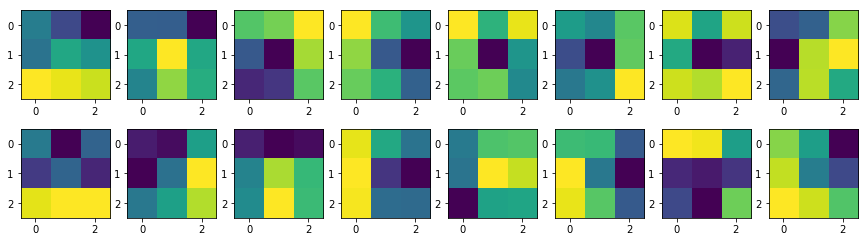

In [ ]:
#CONVOLUTIONAL KERNELS
%matplotlib inline

f, axs = plt.subplots(2,8,figsize=(15,4))
for i in range(16):
    axs.reshape(-1)[i].imshow(model_state["module.inconv.weight"][i,0,0])

In [ ]:
#DATASET
dataset = SentinelDataset("data", tileids="tileids/test_fold0.tileids")
dataloader = torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False,num_workers=0)
iterator = iter(dataloader)

[===========================             ] 1381/2016 ( 68%)  635 to go

rejected_nopath:784, rejected_length:19, total_samples:1213


[========================================] 2016/2016 (100%)    0 to go


In [ ]:
# get single batch
data,label = next(iterator)

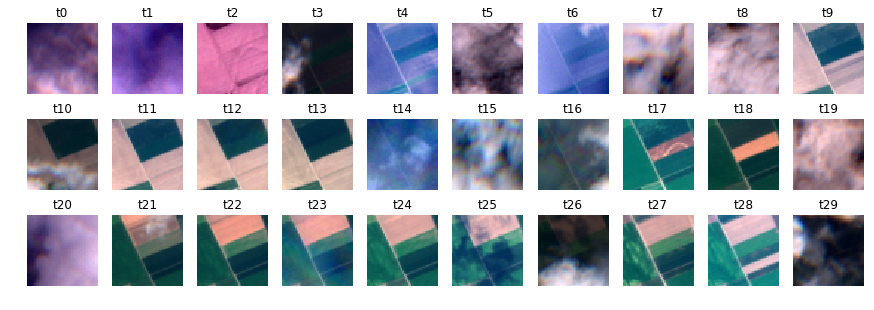

In [ ]:
#NORMALIZATION

f, axs = plt.subplots(3,10,figsize=(15,5))

for i in range(30):
    img = data[0,i,0:3].permute(1,2,0)
    img = ((img-img.min())/(img-img.min()).max()) # normalize
    ax = axs.reshape(-1)[i]
    ax.set_axis_off()
    ax.imshow(img)
    ax.set_title("t"+str(i))

In [ ]:
#PREDICT CLASSES
activations = network.forward(data)
activations = activations.cpu().detach().numpy()

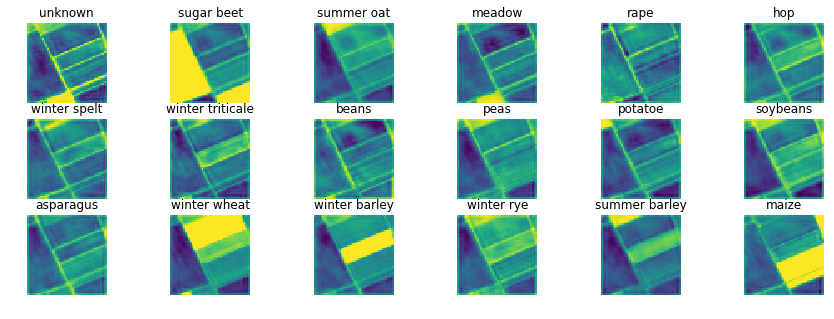

In [ ]:

f, axs = plt.subplots(3,6,figsize=(15,5))
for i in range(18):
    ax = axs.reshape(-1)[i]
    ax.imshow(activations[0,i])
    ax.set_axis_off()
    ax.set_title(dataset.classes[i])

## Compare Ground Truth with Prediction

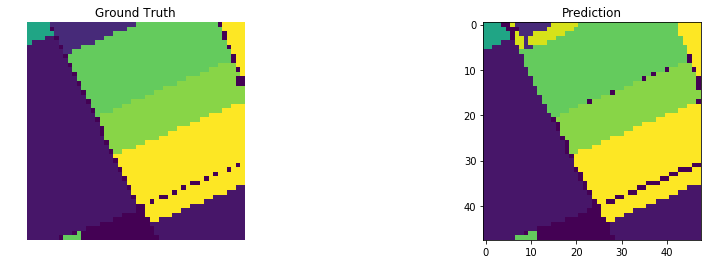

In [ ]:
# GROUND TRUTH VS PREDICTION
f, axs = plt.subplots(1,2,figsize=(15,4))
axs[0].imshow(torch.squeeze(label)); axs[0].set_title("Ground Truth"); axs[0].set_axis_off()
axs[1].imshow(np.argmax(activations[0],axis=0)); axs[1].set_title("Prediction"); axs[0].set_axis_off()